# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="images/pic1.png"/>

Then you will want to run the above command:

<img src="images/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 0. Workflows

We have three assumptions belows:

<img src="images/pic3.png" width="600" />

# 1. Data processing

In [16]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1.1. Portfolio

In [3]:
portfolio.head(20)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


* offer: new  name
* channels: categorial data

In [4]:
# new id
portfolio['offer'] = portfolio.offer_type + '_' + portfolio.difficulty.astype(str) +\
                    '_' + portfolio.duration.astype(str) + '_' + portfolio.reward.astype(str)

# seperate "channels" into multiple columns
channel_set = set()
portfolio["channels"].apply(lambda x: channel_set.update(set(x)))
for channel in channel_set:
    portfolio[channel] = portfolio["channels"].apply(lambda x: 1 if channel in x else 0)
portfolio.drop(["channels"], axis=1, inplace=True)

# display
portfolio.head()

,reward,difficulty,duration,offer_type,id,offer,email,social,mobile,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo_10_7_10,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_10_5_10,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,informational_0_4_0,1,0,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_5_7_5,1,0,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_20_10_5,1,0,0,1


## 1.2. Profile

In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


* Handle missing values
* Create new column called "member_days"
* Rename ID to customer_id

In [6]:
# Handling missing values
print(profile.isnull().sum()) # isnull(), isna() functions are to detect missing values. Both of them do the same thing.

print("Number of invalid age: ", len(profile[profile["age"] == 118]))
profile[profile["age"] == 118].head() 

# Drop record with invalid ages, then all invalid income age are removed
profile = profile[profile["age"] != 118]
print("=======================")
print(profile.isnull().sum()) # isnull(), isna() functions are to detect missing values. Both of them do the same thing.

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
Number of invalid age:  2175
gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64


In [7]:
# Get the last date 
profile["member_days"] = pd.to_datetime(profile["became_member_on"], format='%Y%m%d', errors='ignore')
last_date = profile["member_days"].max()
print("The last record is on date: ", last_date)

# Create member_days and drop became_member_on
profile["member_days"] = (last_date - profile["member_days"]).dt.days
profile.drop(["became_member_on"], axis=1, inplace=True)
profile.head()

The last record is on date:  2018-07-26 00:00:00


,gender,age,id,income,member_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257


In [8]:
profile.rename(columns = {'id':'customer_id'}, inplace = True)
profile.head()

,gender,age,customer_id,income,member_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257


## 1.3. Transcript

In [9]:
transcript.rename(columns = {'person':'fk_customer_id'}, inplace = True) #fk means foreign key
transcript.head()

,fk_customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [11]:
# check transcript["value"]
key_set = set()
transcript["value"].apply(lambda x: key_set.update(x.keys()))
print(key_set)

{'amount', 'reward', 'offer_id', 'offer id'}


In [12]:
def convert(dic):
    if "offer_id" in dic.keys():
        return dic["offer_id"]
    elif "offer id" in dic.keys():
        return dic["offer id"]
    else:
        return np.NaN

# seperate value into small columns
transcript["offer_id"] = transcript["value"].apply(convert)
transcript["amount"] = transcript["value"].apply(lambda dic: dic["amount"] if "amount" in dic.keys() else np.NaN)
transcript["reward"] = transcript["value"].apply(lambda dic: dic["reward"] if "reward" in dic.keys() else np.NaN)
transcript.drop(['value'], axis=1, inplace=True)
transcript.head()

,fk_customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [13]:
# add "offer type" into transcript
temp = portfolio[["id", "offer"]]
temp = pd.merge(transcript, temp, left_on='offer_id', right_on='id', how='left')
temp.drop(["id", "offer_id"], axis=1, inplace=True)

transcript = temp
transcript.head()

,fk_customer_id,event,time,amount,reward,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,bogo_5_7_5
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,discount_20_10_5
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,discount_10_7_2
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,discount_10_10_2
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,bogo_10_5_10


### Transcript processing
Now, we will create the action table by customers.
* n_received: number of offers received by customers
* n_responded: number of offers that the customer responded (receive, view and complete in order)
* n_not_responded: number of offers that the customer did not responded (not complete in the valid time)
* n_n_invalid_responded: number of offers that the customer completed without viewing

<img src="images/pic4.png" width="600" />

In [14]:
# re-order before processing
transcript = transcript.sort_values(by=["offer", "fk_customer_id", "time"]).reset_index(drop=True)
transcript.head(10)

,fk_customer_id,event,time,amount,reward,offer
0,0020c2b971eb4e9188eac86d93036a77,offer received,408,NaN,NaN,bogo_10_5_10
1,0020c2b971eb4e9188eac86d93036a77,offer viewed,426,NaN,NaN,bogo_10_5_10
2,0020c2b971eb4e9188eac86d93036a77,offer completed,510,NaN,10.0,bogo_10_5_10
3,00715b6e55c3431cb56ff7307eb19675,offer received,336,NaN,NaN,bogo_10_5_10
4,00715b6e55c3431cb56ff7307eb19675,offer completed,342,NaN,10.0,bogo_10_5_10
5,00857b24b13f4fe0ad17b605f00357f5,offer received,0,NaN,NaN,bogo_10_5_10
6,00857b24b13f4fe0ad17b605f00357f5,offer viewed,0,NaN,NaN,bogo_10_5_10
7,008d7088107b468893889da0ede0df5c,offer received,504,NaN,NaN,bogo_10_5_10
8,008d7088107b468893889da0ede0df5c,offer viewed,558,NaN,NaN,bogo_10_5_10
9,0091d2b6a5ea4defaa8393e4e816db60,offer received,0,NaN,NaN,bogo_10_5_10


In [132]:
def compute_number(row, n_received, n_viewed, n_responded, n_invalid_responded):
    '''
    Input
        row: a record/row in transcripts
        n_received: number of offers received
        n_viewed: number of offers viewed
        n_responded: number of offers responded
        n_invalid_responded: number of invalid responsed offers (completed but not viewed)
    Output
        n_received, n_responded, n_not_responded, n_invalid_responded: these above number after being aware of the row
    '''
    # increase n_received whenever receiving an offer
    if row["event"] == "offer received":
        n_received = n_received + 1
        
    # assume that the customer is aware of all offers when viewing 
    elif row["event"] == "offer viewed":
        n_viewed = n_received
        
    # assume that offer_completed event happens if and only if an offer is completed within the valid period
    elif row["event"] == "offer completed":
        if n_viewed > n_responded:
            n_responded = n_responded + 1
        else:
            n_invalid_responded = n_invalid_responded + 1
    return n_received, n_viewed, n_responded, n_invalid_responded

In [133]:
def get_num_not_responded(max_recorded_time, deadline, n_received, n_responded, n_invalid_responded):
    n_not_responded = n_received - n_responded - n_invalid_responded
    if (deadline != None and deadline > max_recorded_time):
        n_not_responded = n_not_responded - 1 #cannot justify whether he respond to the latest ad or not
    return n_not_responded

In [134]:
temp = pd.DataFrame(columns=["fk_customer_id", "fk_offer", "n_received", "n_responded", "n_not_responded", "n_invalid_responded"])

max_recorded_time = max(transcript["time"])
offer_list = sorted(portfolio["offer"].unique()) #sort is important

count = 0 #to simplily display progress for each type of offer
max_count = len(transcript[transcript["event"] != "transaction"])

for offer_idx, offer in enumerate(offer_list):    
    print(">>>>>>>>>>> PROCESS for offer: ", offer)
    offer_duration = portfolio[portfolio["offer"] == offer].iloc[0]["duration"]
    sub_trans = transcript[transcript["offer"] == offer]

    customer_id = None
    n_received = n_viewed = n_responded = n_invalid_responded = None
    deadline = None

    for idx, row in sub_trans.iterrows():
        # display progress
        count = count + 1
        if (count % 5000 == 0): #every 1000 rows
            print(count, "/", max_count)

        # if this record is for a new customer, save the result for the previous customer
        if (customer_id != row["fk_customer_id"] and customer_id != None) or (idx == len(transcript)):
            n_not_responded = get_num_not_responded(max_recorded_time, deadline,\
                                                    n_received, n_responded, n_invalid_responded)
            temp = temp.append({"fk_customer_id": customer_id, "fk_offer": offer, "n_received": n_received, "n_responded": n_responded,\
                    "n_not_responded": n_not_responded, "n_invalid_responded": n_invalid_responded}, ignore_index=True)

        # if this record is for a new customer, initilize the numbers
        if (customer_id != row["fk_customer_id"]):
            customer_id = row["fk_customer_id"]
            n_received = n_viewed = n_responded = n_invalid_responded = 0
            deadline = None

        # update customer status and all other numbers
        n_received, n_viewed, n_responded, n_invalid_responded =\
                compute_number(row, n_received, n_viewed, n_responded, n_invalid_responded)
        
        # if receive a new offer, calculate the latest deadline
        if row["event"] == 'offer received':
            deadline = row["time"] + offer_duration * 24
        elif row["event"] == 'offer completed':
            deadline = None
    
temp.head()

>>>>>>>>>>> PROCESS for offer:  bogo_10_5_10
5000 / 167581
10000 / 167581
15000 / 167581
>>>>>>>>>>> PROCESS for offer:  bogo_10_7_10
20000 / 167581
25000 / 167581
30000 / 167581
35000 / 167581
>>>>>>>>>>> PROCESS for offer:  bogo_5_5_5
40000 / 167581
45000 / 167581
50000 / 167581
55000 / 167581
>>>>>>>>>>> PROCESS for offer:  bogo_5_7_5
60000 / 167581
65000 / 167581
70000 / 167581
>>>>>>>>>>> PROCESS for offer:  discount_10_10_2
75000 / 167581
80000 / 167581
85000 / 167581
90000 / 167581
>>>>>>>>>>> PROCESS for offer:  discount_10_7_2
95000 / 167581
100000 / 167581
105000 / 167581
>>>>>>>>>>> PROCESS for offer:  discount_20_10_5
110000 / 167581
115000 / 167581
120000 / 167581
>>>>>>>>>>> PROCESS for offer:  discount_7_7_3
125000 / 167581
130000 / 167581
135000 / 167581
140000 / 167581
>>>>>>>>>>> PROCESS for offer:  informational_0_3_0
145000 / 167581
150000 / 167581
155000 / 167581
>>>>>>>>>>> PROCESS for offer:  informational_0_4_0
160000 / 167581
165000 / 167581


,fk_customer_id,fk_offer,n_received,n_responded,n_not_responded,n_invalid_responded
0,0020c2b971eb4e9188eac86d93036a77,bogo_10_5_10,1,1,0,0
1,00715b6e55c3431cb56ff7307eb19675,bogo_10_5_10,1,0,0,1
2,00857b24b13f4fe0ad17b605f00357f5,bogo_10_5_10,1,0,1,0
3,008d7088107b468893889da0ede0df5c,bogo_10_5_10,1,0,1,0
4,0091d2b6a5ea4defaa8393e4e816db60,bogo_10_5_10,2,1,1,0


In [135]:
temp.head(10)

,fk_customer_id,fk_offer,n_received,n_responded,n_not_responded,n_invalid_responded
0,0020c2b971eb4e9188eac86d93036a77,bogo_10_5_10,1,1,0,0
1,00715b6e55c3431cb56ff7307eb19675,bogo_10_5_10,1,0,0,1
2,00857b24b13f4fe0ad17b605f00357f5,bogo_10_5_10,1,0,1,0
3,008d7088107b468893889da0ede0df5c,bogo_10_5_10,1,0,1,0
4,0091d2b6a5ea4defaa8393e4e816db60,bogo_10_5_10,2,1,1,0
5,0099bf30e4cb4265875266eb3eb25eab,bogo_10_5_10,1,0,1,0
6,00a794f62b9a48beb58f8f6c02c2f1a6,bogo_10_5_10,1,0,1,0
7,00ad4c2cace94f67a6354ec90d6c6f45,bogo_10_5_10,1,0,1,0
8,00b3c376db2a4115af3aef34a02f61d6,bogo_10_5_10,1,0,0,1
9,00c20a9202d5475190b31a24de6fb06d,bogo_10_5_10,1,1,0,0


In [116]:
# examine the first 15 rows
transcript[transcript["offer"] == "bogo_10_5_10"].head(20)

,fk_customer_id,event,time,amount,reward,offer
0,0020c2b971eb4e9188eac86d93036a77,offer received,408,NaN,NaN,bogo_10_5_10
1,0020c2b971eb4e9188eac86d93036a77,offer viewed,426,NaN,NaN,bogo_10_5_10
2,0020c2b971eb4e9188eac86d93036a77,offer completed,510,NaN,10.0,bogo_10_5_10
3,00715b6e55c3431cb56ff7307eb19675,offer received,336,NaN,NaN,bogo_10_5_10
4,00715b6e55c3431cb56ff7307eb19675,offer completed,342,NaN,10.0,bogo_10_5_10
5,00857b24b13f4fe0ad17b605f00357f5,offer received,0,NaN,NaN,bogo_10_5_10
6,00857b24b13f4fe0ad17b605f00357f5,offer viewed,0,NaN,NaN,bogo_10_5_10
7,008d7088107b468893889da0ede0df5c,offer received,504,NaN,NaN,bogo_10_5_10
8,008d7088107b468893889da0ede0df5c,offer viewed,558,NaN,NaN,bogo_10_5_10
9,0091d2b6a5ea4defaa8393e4e816db60,offer received,0,NaN,NaN,bogo_10_5_10


In [130]:
# examine a person's record

# transcript[transcript['fk_customer_id']=='fe97aa22dd3e48c8b143116a8403dd52'].head(100)
# transcript[transcript['fk_customer_id']=='6d2db3aad94648259e539920fc2cf2a6'].head(100)
# transcript[transcript['fk_customer_id']=='33834c812b4e47e4955093ad03f6117a'].head(100)
# transcript[transcript['fk_customer_id']=='01925607d99c460996c281f17cdbb9e2'].head(100)
transcript[transcript['fk_customer_id']=='0009655768c64bdeb2e877511632db8f'].head(100)

,fk_customer_id,event,time,amount,reward,offer
36284,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,NaN,bogo_5_5_5
36285,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,5.0,bogo_5_5_5
36286,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,NaN,bogo_5_5_5
71617,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,NaN,discount_10_10_2
71618,0009655768c64bdeb2e877511632db8f,offer completed,528,NaN,2.0,discount_10_10_2
71619,0009655768c64bdeb2e877511632db8f,offer viewed,540,NaN,NaN,discount_10_10_2
91858,0009655768c64bdeb2e877511632db8f,offer received,576,NaN,NaN,discount_10_7_2
91859,0009655768c64bdeb2e877511632db8f,offer completed,576,NaN,2.0,discount_10_7_2
141515,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,informational_0_3_0
141516,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,informational_0_3_0


In [136]:
# save
temp.to_pickle('cache/customer_offer_response.pkl')

# 2. Data analysis

## 2.1. Customer response

In [18]:
# remove information offers
temp = pd.read_pickle('cache/customer_offer_response.pkl')
number = temp[~temp["fk_offer"].str.contains('info')]
number.shape

(50629, 6)

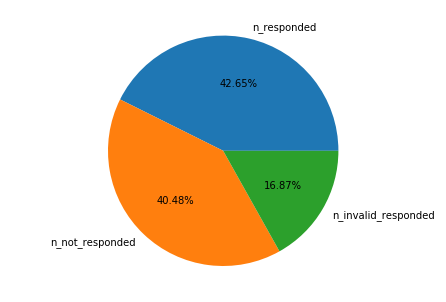

In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
events = ['n_responded', 'n_not_responded', 'n_invalid_responded']
numbers = [number["n_responded"].sum(),number["n_not_responded"].sum(),number["n_invalid_responded"].sum()]
ax.pie(numbers, labels = events, autopct='%1.2f%%')
plt.show()

__Findings:__
* In general, 40% of offerred was not responded. 
* Interestinly, the customers completed up to 17% of offers without viewing those offer in advance

## 2.2. Customer type

In [20]:
df = number.groupby(["fk_customer_id"])[["n_received", "n_responded", "n_not_responded", "n_invalid_responded"]].sum()

In [21]:
def get_type(row):
    '''
        type 1: respond to all
        type 2: at least one response
        type 3: dont care
        type 3: never respond
        type 4: no offer
    '''
    if row["n_responded"] > 0:
        if row["n_not_responded"] + row["n_invalid_responded"] == 0:
            return "always_respond"
        else:
            return "has_response"
    else:
        if row["n_invalid_responded"] > 0:
            return "dont_care"
        elif row["n_not_responded"] > 0:
            return "never_respond"
        else:
            return "no_offer"

df["type"] = df.apply(lambda row: get_type(row), axis = 1)
df.head()

,n_received,n_responded,n_not_responded,n_invalid_responded,type
fk_customer_id,,,,,
0009655768c64bdeb2e877511632db8f,3,0,0,3,dont_care
00116118485d4dfda04fdbaba9a87b5c,2,0,2,0,never_respond
0011e0d4e6b944f998e987f904e8c1e5,3,3,0,0,always_respond
0020c2b971eb4e9188eac86d93036a77,4,2,1,1,has_response
0020ccbbb6d84e358d3414a3ff76cffd,3,3,0,0,always_respond


has_response      63.64
never_respond     27.64
always_respond    15.45
dont_care          7.07
no_offer           0.38
Name: type, dtype: float64


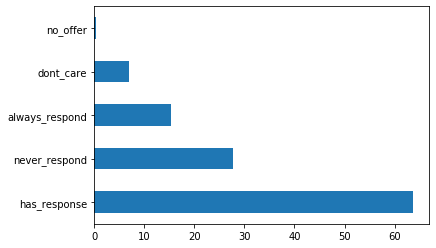

In [22]:
temp = round(df["type"].value_counts() * 10000 / len(profile)) / 100
temp.plot(kind='barh')
print(temp)

__Findings:__
* There are 0.38% customers who have offers but the valid period was not finished. so we dont consider them in _never_respond_ group
* 7.1% customers are loyal users, they just bought products regardless of offers. Starbucks may send offer infrequently to save its cost
* 27.7% customers have never responded to offers. Starbucks may create another offer which focuses on this group
* 15.5% customers always respond to offers. Starbucks may create a campaign strategy to increase revenue or loan considering this group

## 2.3. Customer characteristics

In [23]:
temp = pd.merge(profile, df, left_on='customer_id', right_on='fk_customer_id', how='left')
temp.head()

,gender,age,customer_id,income,member_days,n_received,n_responded,n_not_responded,n_invalid_responded,type
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376,1.0,0.0,0.0,1.0,dont_care
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,3.0,2.0,0.0,1.0,has_response
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91,3.0,2.0,1.0,0.0,has_response
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167,6.0,5.0,1.0,0.0,has_response
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,2.0,1.0,1.0,0.0,has_response


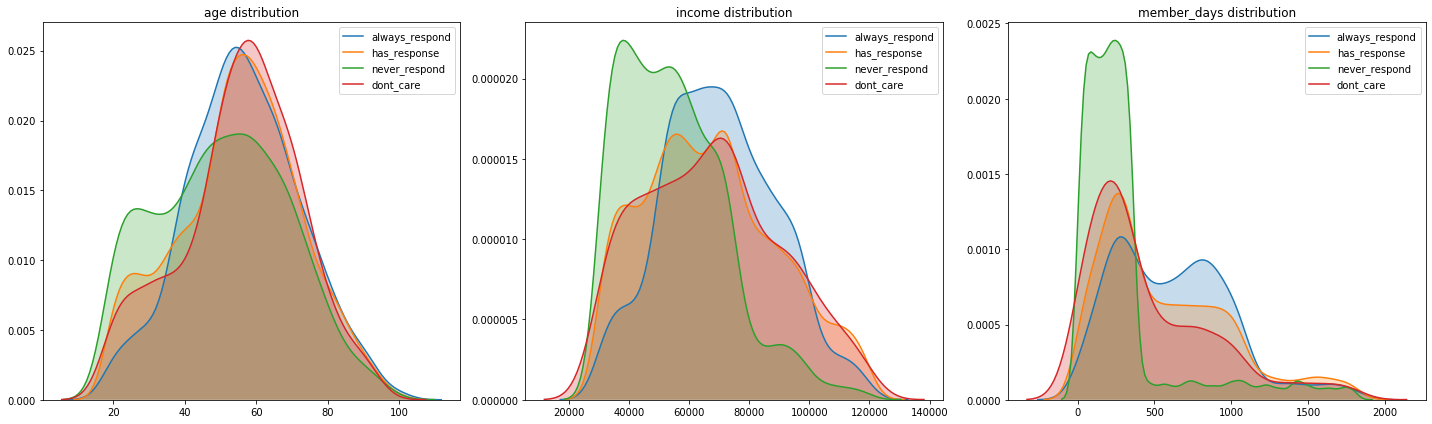

In [24]:
plt.figure(figsize=(20,6))

for i, feature in enumerate(['age','income','member_days']):
    plt.subplot(1,3,i+1)
    sns.kdeplot(temp[temp["type"] == "always_respond"][feature], shade=True, label='always_respond')
    sns.kdeplot(temp[temp["type"] == "has_response"][feature], shade=True, label='has_response')
    sns.kdeplot(temp[temp["type"] == "never_respond"][feature], shade=True, label='never_respond')
    sns.kdeplot(temp[temp["type"] == "dont_care"][feature], shade=True, label='dont_care')
    plt.legend(); plt.title(f'{feature} distribution')
    plt.tight_layout()

__Findings:__
* Customers who have __never respond__ (green curve) are mostly young in age, have low income, and have a short length of membership. It may be because new members don’t know how to navigate around the app and respond to the offers.
* Customers who __always respond__ (blue curve) are average in income, and average in length of membership
* Customers who __do not care__ about campain (red_curve) has higher income and longer membership (but the differences are not significant)

__Others:__
* Customer segmentation are recommended to get insight from data

## 2.4. BOGO vs discount

In [38]:
df = number.copy()
df["type"] = df.apply(lambda row: get_type(row), axis = 1)
df.head()

,fk_customer_id,fk_offer,n_received,n_responded,n_not_responded,n_invalid_responded,type
0,0020c2b971eb4e9188eac86d93036a77,bogo_10_5_10,1,1,0,0,always_respond
1,00715b6e55c3431cb56ff7307eb19675,bogo_10_5_10,1,0,0,1,dont_care
2,00857b24b13f4fe0ad17b605f00357f5,bogo_10_5_10,1,0,1,0,never_respond
3,008d7088107b468893889da0ede0df5c,bogo_10_5_10,1,0,1,0,never_respond
4,0091d2b6a5ea4defaa8393e4e816db60,bogo_10_5_10,2,1,1,0,has_response


In [71]:
# number of offers
df = number.groupby(["fk_offer"])[["fk_customer_id"]].count()
df.head(20)

,fk_customer_id
fk_offer,
bogo_10_5_10,6329
bogo_10_7_10,6373
bogo_5_5_5,6261
bogo_5_7_5,6354
discount_10_10_2,6331
discount_10_7_2,6284
discount_20_10_5,6373
discount_7_7_3,6324


                 fk_customer_id                                              
type             always_respond dont_care has_response never_respond no_offer
fk_offer                                                                     
bogo_10_5_10             2137.0     402.0        346.0        3444.0      0.0
bogo_10_7_10             2035.0     784.0        358.0        2763.0    433.0
bogo_5_5_5               2719.0     536.0        485.0        2521.0      0.0
bogo_5_7_5               1621.0    1751.0        411.0        2165.0    406.0
discount_10_10_2         3777.0     429.0        323.0        1177.0    625.0
discount_10_7_2          1611.0    1481.0        387.0        2411.0    394.0
discount_20_10_5         1042.0    1715.0        220.0        2362.0   1034.0
discount_7_7_3           3482.0     524.0        414.0        1596.0    308.0


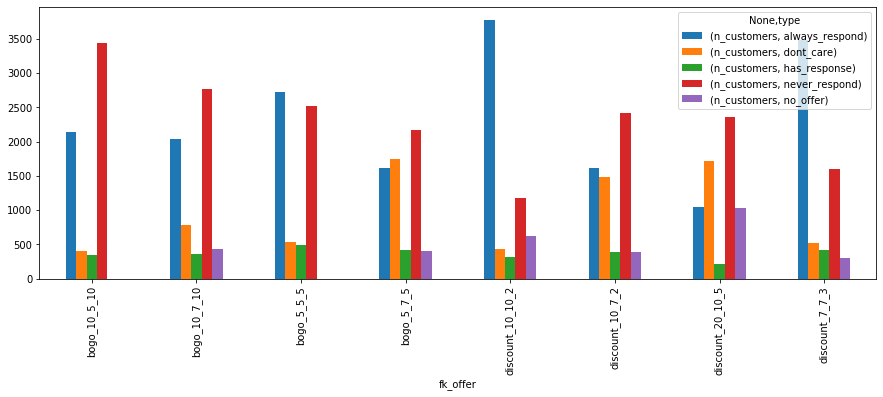

In [79]:
df = number.groupby(["fk_offer","type"])[["fk_customer_id"]].count().unstack()
df = df.fillna(0)
print(df.head(10))

df.rename(columns = {"fk_customer_id": "n_customers"}, inplace = True)
df.plot.bar(figsize=(15,5))

__Findings:__
* The number of an offer is about 6300
* Customers respond to discount better than bogo
* Among all types of offer, customers responded to discount_10_10_2 and discount_7_7_3 the most. On the other words, people prefer discount with lower minimum spend and longer expiration days

__Others:__
* The offer approaches are not considered in this investigation

# 3. Future work

### Possible tasks
1. Customer segmentation
2. Customer type predictation: to predict whether customer respond to offer or not

However, we do not cover them here because:
* This task has smaller datasets compared to the Arvato project. So, we leave this for future work
* Starbucks has many products, so 1 product is not enough to clusify customers

### Customer features for the two tasks:

Each customers have following 36 attributes:
* number of transactions per week
* amount of money per transaction
* age
* income
* n_received (8 types of offers)
* n_responded (8 types of offers)
* n_not_responded (8 types of offers)
* n_invalid_responded (8 types of offers)

One problem of seperating train/test sets is that if we use 36 features as explained before, a feature (e.g. number of transaction per week) may contain the informaiton of the whole month. On the other words, there is relationship between the feature and the customer type

# Conclusions
In this project, we perform data processing and data analytic based on Starbucks dataset. The most important thing is to understand the business flow. A lot of solutions are failed in this task because they simply evalutate the number of offer_received, offer_viewed and offer_complete while ingoring their orders and the time instant those event happens. .

After analysing the data, we have some findings:
* 40% of offerred was not responded. Starbucks and use this number to evaluate its campaign success
* 7.1% customers are loyal users, they just bought products regardless of offers. Starbucks may send offer infrequently to save its cost
* 27.7% customers have never responded to offers. They are mostly young in age, have low income, and have a short length of membership. One possible reason is that new members don’t know how to navigate around the app and respond to the offers. Also, Starbucks may create another offer which focuses on this group
* Customers respond to discount offer better than BOGO offer. Among all types of discount, people prefer discount with lower minimum spend and longer expiration days

Since customer segmentation and prediction tasks are somehow similar to that in Arvato project but in a smaller scale (1 month duration + small numbers of features), we decided to leave them for future work. 